<a href="https://colab.research.google.com/github/intimanjunath/Dimensionality_Reduction/blob/main/data_bricks_Demonstrate_dimensionality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark umap-learn tensorflow matplotlib numpy pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA as skPCA
from mpl_toolkits.mplot3d import Axes3D

In [6]:
#Synthetic Data Generation
def create_2D_gaussian(mean, variance, cov, n):
    """
    Generates synthetic 2D data using Gaussian distribution.
    Args:
        mean (float): Mean of the distribution.
        variance (float): Variance of the distribution.
        cov (float): Covariance between the dimensions.
        n (int): Number of samples to generate.
    Returns:
        np.ndarray: Generated 2D data.
    """
    np.random.seed(42)
    return np.random.multivariate_normal(
        [mean, mean],
        [[variance, cov], [cov, variance]],
        n
    )

# Generate Data
data_uncorrelated = create_2D_gaussian(mean=50, variance=1, cov=0, n=100)
data_correlated = create_2D_gaussian(mean=50, variance=1, cov=0.9, n=100)

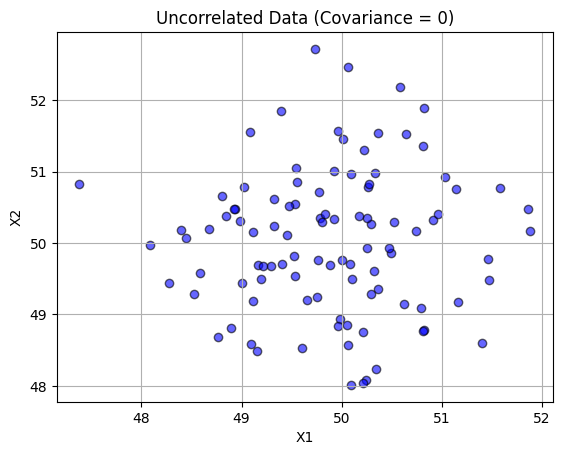

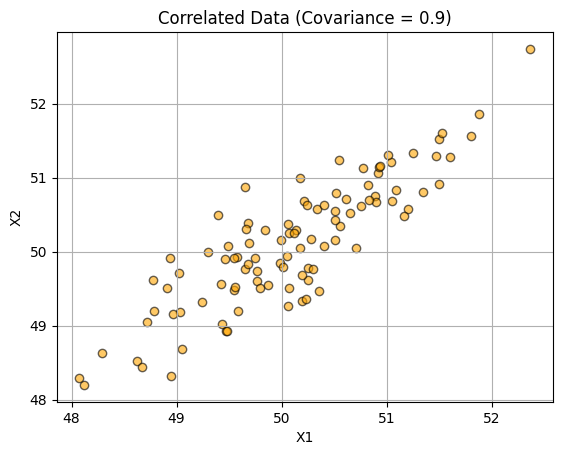

In [7]:
def plot_2D_data(data, title, color):
    """
    Plots 2D Gaussian data.
    Args:
        data (np.ndarray): 2D data.
        title (str): Plot title.
        color (str): Color of the points.
    """
    plt.scatter(data[:, 0], data[:, 1], c=color, alpha=0.6, edgecolor='k')
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid()
    plt.show()

# Visualize Uncorrelated Data
plot_2D_data(data_uncorrelated, "Uncorrelated Data (Covariance = 0)", "blue")

# Visualize Correlated Data
plot_2D_data(data_correlated, "Correlated Data (Covariance = 0.9)", "orange")

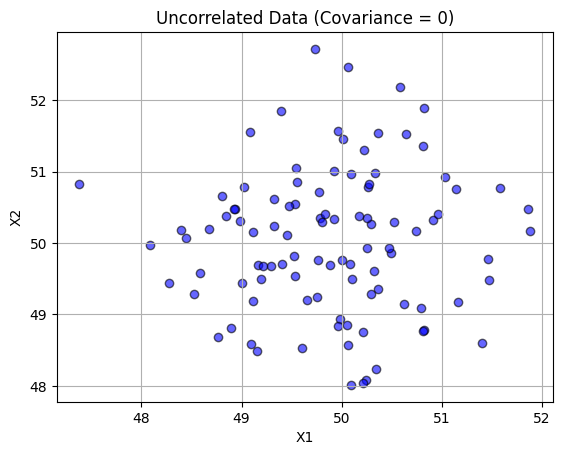

In [25]:
plot_2D_data(data_uncorrelated, "Uncorrelated Data (Covariance = 0)", "blue")

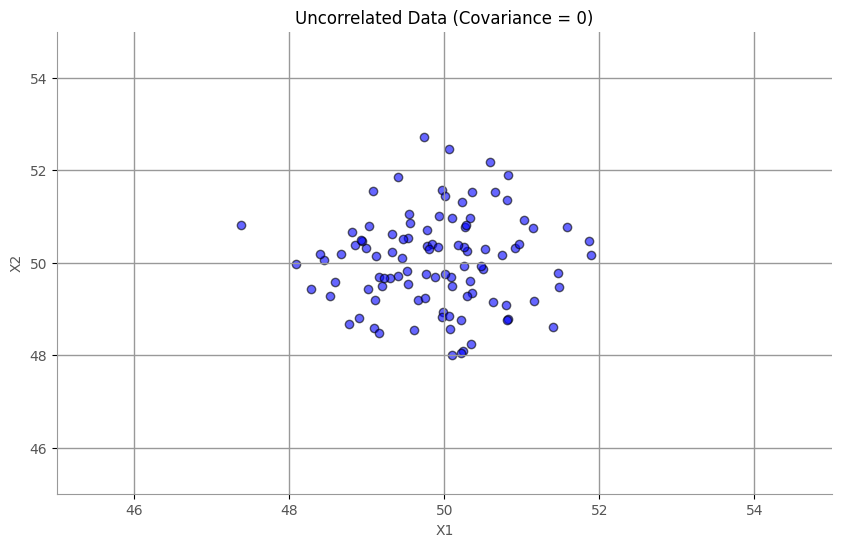

In [26]:
fig, ax = prepare_plot(np.arange(40, 60, 2), np.arange(40, 60, 2))
ax.set_xlabel("X1", color='#555555')
ax.set_ylabel("X2", color='#555555')
ax.set_xlim(45, 55)
ax.set_ylim(45, 55)

# Scatter Plot
scatter = ax.scatter(data_uncorrelated[:, 0], data_uncorrelated[:, 1], c='blue', alpha=0.6, edgecolor='k')
plt.title("Uncorrelated Data (Covariance = 0)")
plt.show()

In [8]:
# Generate 3D Gaussian Data
def create_3D_gaussian(mean, covariance, n):
    """
    Generates synthetic 3D data using a Gaussian distribution.
    Args:
        mean (list): Mean values for the three dimensions.
        covariance (list): Covariance matrix for the distribution.
        n (int): Number of data points to generate.
    Returns:
        np.ndarray: Generated 3D data points.
    """
    np.random.seed(42)
    return np.random.multivariate_normal(mean, covariance, n)

# Define Mean and Covariance
mean_3d = [50, 50, 50]
covariance_3d = [
    [25, 15, 10],  # Variance and Covariance for X1
    [15, 30, 20],  # Variance and Covariance for X2
    [10, 20, 40]   # Variance and Covariance for X3
]

# Generate Data
data_3d = create_3D_gaussian(mean=mean_3d, covariance=covariance_3d, n=200)

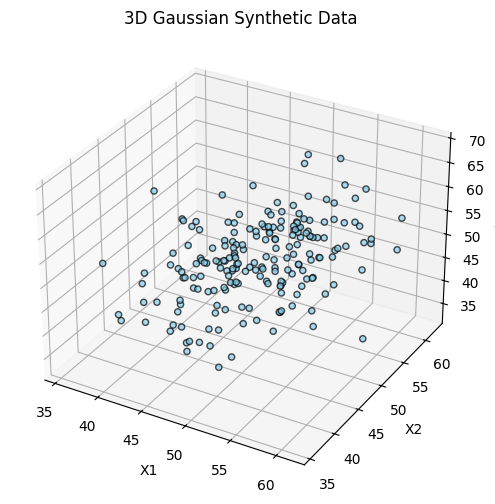

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_data(data, title):
    """
    Plots 3D Gaussian data using a scatter plot.
    Args:
        data (np.ndarray): 3D data points.
        title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='skyblue', alpha=0.7, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    plt.show()

# Visualize 3D Data
plot_3D_data(data_3d, "3D Gaussian Synthetic Data")

In [10]:
# PCA using PySpark

In [11]:
# Initialize Spark Session
spark = SparkSession.builder.appName("DimensionalityReduction").getOrCreate()

In [12]:
# Load Dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

# Convert to Spark DataFrame
spark_iris_df = spark.createDataFrame(iris_df)
spark_iris_df.show(5)

+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2|      0|
|              4.9|             3.0|              1.4|             0.2|      0|
|              4.7|             3.2|              1.3|             0.2|      0|
|              4.6|             3.1|              1.5|             0.2|      0|
|              5.0|             3.6|              1.4|             0.2|      0|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows



In [13]:
# Assemble Features
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
assembled_data = assembler.transform(spark_iris_df)

# Scale Features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaled_data = scaler.fit(assembled_data).transform(assembled_data)
scaled_data.select("scaled_features").show(5)

+--------------------+
|     scaled_features|
+--------------------+
|[-0.8976738791967...|
|[-1.1392004834649...|
|[-1.3807270877331...|
|[-1.5014903898672...|
|[-1.0184371813308...|
+--------------------+
only showing top 5 rows



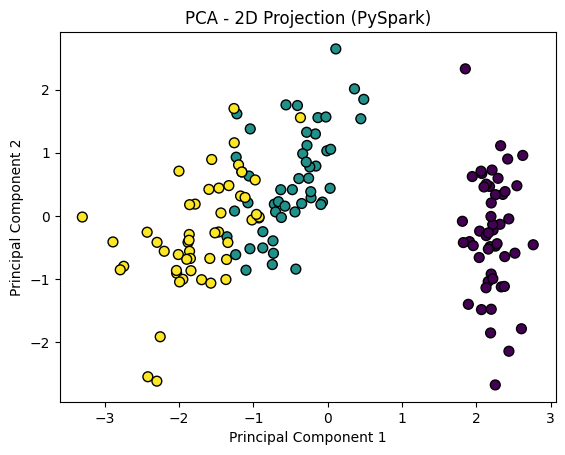

In [14]:
# Perform PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
pca_data = pca_model.transform(scaled_data)

# Extract Results
pca_features = np.array(pca_data.select("pca_features").rdd.map(lambda row: row[0]).collect())
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=iris.target, cmap='viridis', s=50, edgecolors='k')
plt.title("PCA - 2D Projection (PySpark)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [23]:
# Define prepare_plot
def prepare_plot(xticks, yticks, figsize=(10, 6), grid_color='#999999', grid_width=1.0):
    """
    Template for generating the plot layout.
    Args:
        xticks (array-like): Tick marks for x-axis.
        yticks (array-like): Tick marks for y-axis.
        figsize (tuple): Figure size.
        grid_color (str): Color of the grid.
        grid_width (float): Width of the grid lines.
    Returns:
        fig, ax: Figure and axis objects.
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.tick_params(labelcolor='#555555', labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(grid_color)
    ax.spines['bottom'].set_color(grid_color)
    return fig, ax

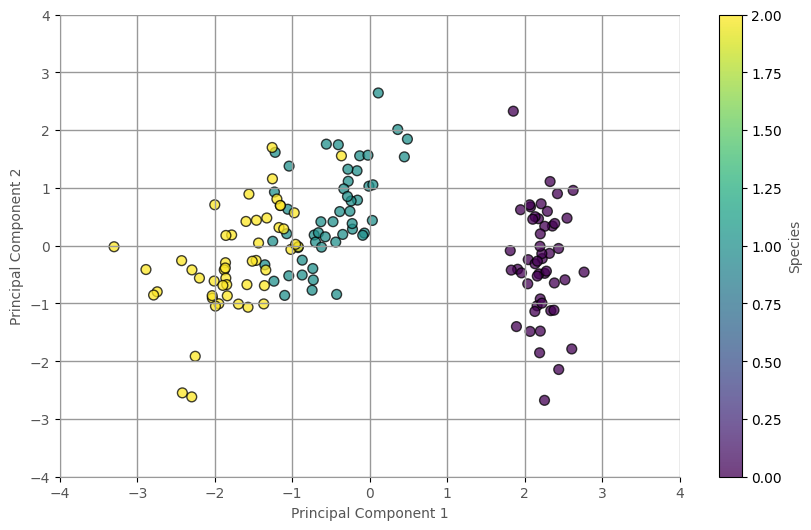

In [24]:
# Extract Results
pca_features = np.array(pca_data.select("pca_features").rdd.map(lambda row: row[0]).collect())

# Custom Plot with prepare_plot
fig, ax = prepare_plot(np.arange(-5, 5, 1), np.arange(-5, 5, 1))  # Adjust ticks as per your data range
ax.set_xlabel(r"Principal Component 1", color='#555555')
ax.set_ylabel(r"Principal Component 2", color='#555555')
ax.set_xlim(-4, 4)  # Set appropriate limits for your PCA data
ax.set_ylim(-4, 4)

# Scatter Plot with Customization
scatter = ax.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=iris.target,
    cmap='viridis',
    s=50,
    edgecolors='k',
    alpha=0.75
)

# Add Colorbar for Interpretation
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Species", color='#555555')

# Display Plot
plt.show()

In [15]:
# PCA with 3D Data and Visualization
mean = [50, 50, 50]
cov_matrix = [[25, 10, 5], [10, 400, 20], [5, 20, 400]]
data_3d = np.random.multivariate_normal(mean, cov_matrix, 200)

In [16]:
# Apply PCA
pca_3d = skPCA(n_components=3)
pca_3d.fit(data_3d)
components = pca_3d.components_
projected_data = data_3d @ components[:2].T

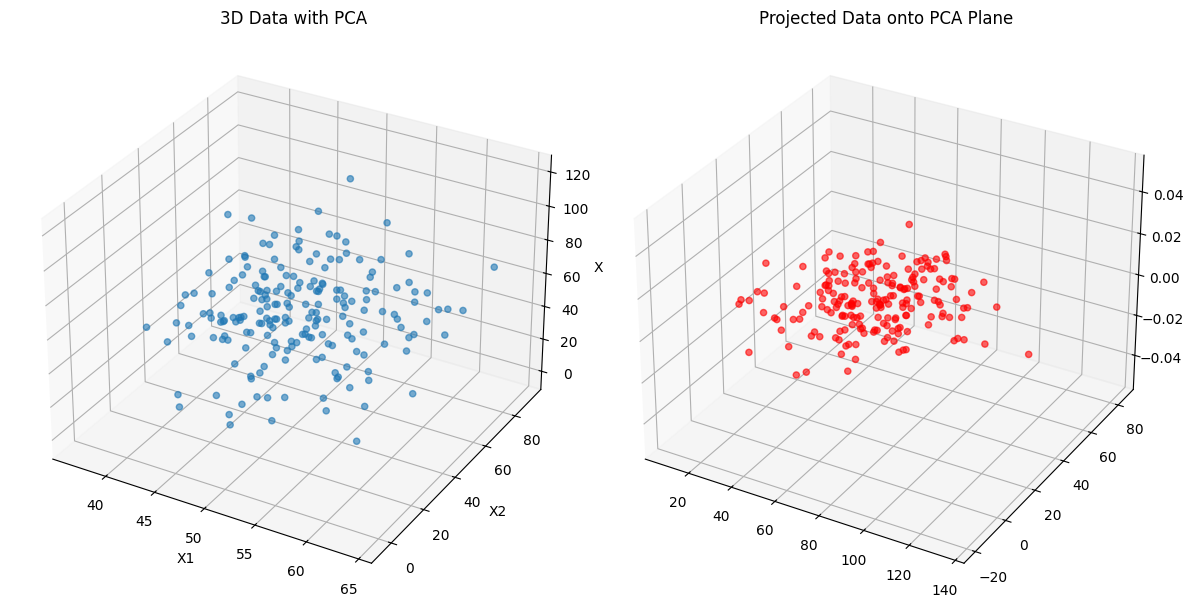

In [21]:
fig = plt.figure(figsize=(12, 6))

# Plot Original Data
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], alpha=0.6, label="Original Data")
ax.set_title("3D Data with PCA")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")

# Plot Projected Data
ax = fig.add_subplot(122, projection='3d')
ax.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.6, color='red', label="Projected Data")
ax.set_title("Projected Data onto PCA Plane")
plt.tight_layout()
plt.show()